In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


In [2]:
import os  # Add this line at the beginning of your code

save_dir = '/kaggle/working/'  # Specify your directory path
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [3]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os

# Paths to the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata CSV
labels = pd.read_csv(metadata_file)

# Convert diagnosis (dx) to integers (you can map specific diseases if needed)
label_mapping = {label: idx for idx, label in enumerate(labels['dx'].unique())}
labels['dx'] = labels['dx'].map(label_mapping)

# Set image size for the model
IMG_SIZE = 128  # Resize images to 128x128

# Function to load and preprocess images
def load_images_and_labels(labels, image_dir_1, image_dir_2, img_size=128):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize to [-1,1] for tanh activation
        img_array = image.img_to_array(img) / 127.5 - 1.0  # Normalize to [-1,1]
        images.append(img_array)
        label_list.append(row['dx'])  # Add the label (dx)

    X = np.array(images)
    y = np.array(label_list)
    return X, y

# Load the images and labels with new image size
X, y = load_images_and_labels(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Adjust dataset split to be closer to 85-10-5 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)


# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Compute class weights to handle class imbalance
def compute_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(labels), y=labels
    )
    return {i: class_weights[i] for i in range(len(class_weights))}

class_weights = compute_class_weights(y_train)

# Define the new data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

# Apply augmentation to the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda img: data_augmentation(img)
)

# Normalization for the validation set (no augmentation)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Creating data pipeline for training and validation
train_dataset = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)
val_dataset = val_datagen.flow(X_val, y_val_one_hot, batch_size=32)

# Efficient data pipeline
def create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot)).shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return train_data, val_data, test_data

batch_size = 32
train_data, val_data, test_data = create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size)

# Check the final dataset split
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (8512, 128, 128, 3)
Validation set: (1002, 128, 128, 3)
Test set: (501, 128, 128, 3)


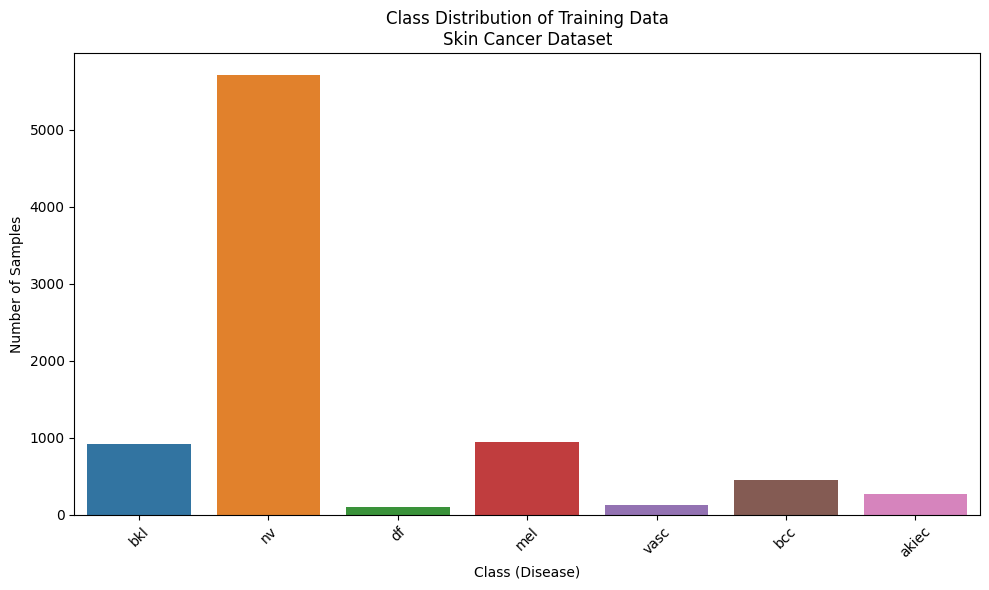

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add disease names for better interpretation
disease_labels = {v: k for k, v in label_mapping.items()}

# Update the plot function to show disease names on the x-axis
def plot_class_distribution(y_original, title, disease_labels):
    y_original_series = pd.Series(y_original)
    
    # Get class distribution counts
    original_class_dist = y_original_series.value_counts().sort_index()
    
    # Plot the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=original_class_dist.index, y=original_class_dist.values)
    plt.title(f'Class Distribution of Training Data\n{title}')
    plt.xlabel('Class (Disease)')
    plt.ylabel('Number of Samples')
    
    # Update x-axis ticks to show disease names
    plt.xticks(
        ticks=original_class_dist.index, 
        labels=[disease_labels.get(i, str(i)) for i in original_class_dist.index], 
        rotation=45
    )
    
    plt.tight_layout()
    plt.show()

# Call the updated function to plot the class distribution of the original training data
plot_class_distribution(y_train, 'Skin Cancer Dataset', disease_labels)


Random Images from Each Class:


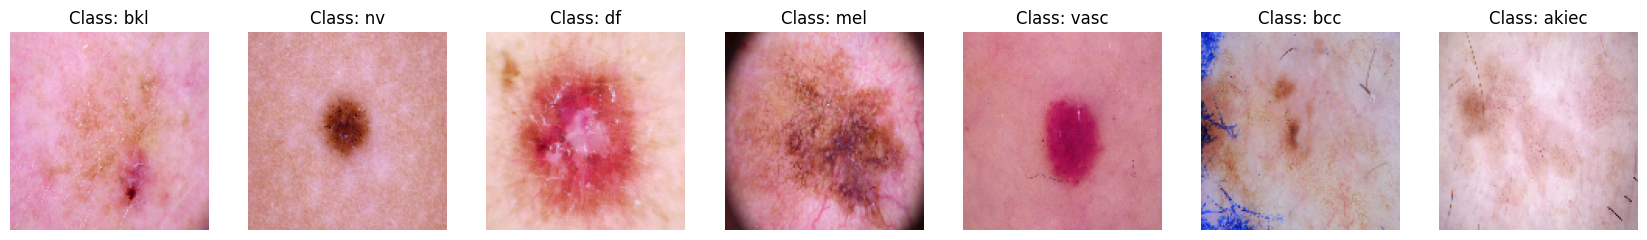

In [6]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to display a random image from each class
def display_random_images_by_class(X, y, labels, num_classes=7, img_size=128):
    # Create a figure to display images
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))

    # Check if y is one-hot encoded
    if len(y.shape) == 2 and y.shape[1] == num_classes:
        y_labels = np.argmax(y, axis=1)  # If one-hot encoded, convert back to class labels
    else:
        y_labels = y  # If already class labels, use them directly

    for class_idx in range(num_classes):
        # Find all images that belong to the current class
        class_indices = np.where(y_labels == class_idx)[0]  # Get indices of images from the current class
        
        # Pick a random index from the class
        random_index = random.choice(class_indices)
        
        # Get the image and its corresponding label
        random_img = X[random_index]
        random_label = class_idx
        
        # Convert image array back to displayable format
        random_img_display = image.array_to_img(random_img)
        
        # Display the image in the corresponding subplot
        axes[class_idx].imshow(random_img_display)
        axes[class_idx].set_title(f"Class: {labels[random_label]}")
        axes[class_idx].axis('off')  # Hide axes for clarity
    
    # Show the final plot
    plt.show()

# Display a random image from each class
def visualize_random_images_by_class(X_train, y_train, labels_reverse, num_classes=7, img_size=128):
    print("Random Images from Each Class:")
    display_random_images_by_class(X_train, y_train, labels_reverse, num_classes, img_size)

# Convert label back to its original class name using the 'label_mapping'
labels_reverse = {v: k for k, v in label_mapping.items()}  # Reverse the label mapping

# Visualize a random image from each class in the training data
visualize_random_images_by_class(X_train, y_train, labels_reverse, num_classes=7, img_size=128)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Set latent dimension and number of classes
latent_dim = 100  # Latent dimension (size of the compressed representation)
num_classes = 7   # Set the number of classes for classification in the discriminator

# Encoder (Updated with more layers and LeakyReLU)
encoder = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Changed to 128x128
    layers.Conv2D(16, kernel_size=3, strides=2, padding="same", activation=None),  # (128, 128) -> (64, 64, 16)
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.2),
    
    layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation=None),  # (64, 64) -> (32, 32, 32)
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.2),
    
    layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation=None),  # (32, 32) -> (16, 16, 64)
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.2),
    
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation (128)
])

# Decoder (Updated to output 128x128 with more layers and LeakyReLU)
decoder = tf.keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(16 * 16 * 64, activation="relu"),  # Upscale to match the desired dimensions
    layers.Reshape((16, 16, 64)),  # Shape after first dense layer
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation=None),  # (32, 32, 64)
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.2),
    
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation=None),  # (64, 64, 32)
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.2),
    
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation=None),  # (128, 128, 16)
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=0.2),
    
    layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='tanh'),  # (128, 128, 3)
])

# Full autoencoder model
autoencoder_input = layers.Input(shape=(128, 128, 3))  # Changed input shape to (128, 128, 3)
latent_representation = encoder(autoencoder_input)
reconstructed_image = decoder(latent_representation)

autoencoder = models.Model(inputs=autoencoder_input, outputs=reconstructed_image)

# Create a new optimizer instance for the autoencoder
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)

# Recompile the autoencoder model with the new optimizer
autoencoder.compile(optimizer=opt_autoencoder, loss='mse')
autoencoder.summary()

# Define the Generator (decoder of the autoencoder)
def create_generator(latent_dim):
    model = tf.keras.Sequential()

    # Latent vector input shape (128,)
    model.add(layers.Input(shape=(latent_dim,)))

    # Fully connected layer to reshape latent vector into a 3D tensor
    model.add(layers.Dense(8 * 8 * 128, activation='relu'))  # Flatten to size (8, 8, 128)
    model.add(layers.Reshape((8, 8, 128)))  # Reshape into (8, 8, 128)

    # Upsample to 128x128 using Conv2DTranspose
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'))  # (16, 16, 128)
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))   # (32, 32, 64)
    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'))   # (64, 64, 32)
    model.add(layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'))   # (128, 128, 16)
    model.add(layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh'))  # (128, 128, 3)

    return model

# Create the generator model
generator = create_generator(latent_dim)

# Display the generator summary
generator.summary()

import tensorflow as tf
from tensorflow.keras import layers, models

import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers

def create_discriminator(input_shape=(128, 128, 3), num_classes=7):
    model = models.Sequential()
    
    # First convolutional layer with L2 regularization and dropout
    model.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, 
                            padding='same', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))  # Dropout to prevent overfitting
    
    # Second convolutional layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.0005)))  
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))  

    # Third convolutional layer
    model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0005)))  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))  

    # Fourth convolutional layer
    model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='valid', kernel_regularizer=regularizers.l2(0.0005)))  
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))  

    # Flatten the feature maps
    model.add(layers.Flatten())  

    # Dense layer (fully connected) with 64 units
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.Dropout(0.4))  
    
    # Fully connected (dense) layer with 32 units
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(layers.Dropout(0.4))  

    # Output layer with Softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))  

    # Define the optimizer with learning rate 0.00005
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    opt_disc = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5, beta_2=0.999)

    model.compile(optimizer=opt_disc, loss=loss_fn, metrics=['accuracy'])
    
    return model

# Create the discriminator model
discriminator = create_discriminator(input_shape=(128, 128, 3), num_classes=7)

# Display the discriminator summary
discriminator.summary()

# Create the GAN model
def create_gan(generator, discriminator, latent_dim=100):
    # Freeze the discriminator during the generator training
    discriminator.trainable = True

    gan_input = layers.Input(shape=(latent_dim,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = models.Model(gan_input, gan_output)
    
    # Compile the GAN with categorical cross-entropy loss for multi-class classification
    gan.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=['accuracy'])
    
    return gan

# Create the GAN model
gan = create_gan(generator, discriminator, latent_dim=latent_dim)

# Display the GAN model summary
gan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 100)                 │       1,662,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 128, 128, 3)         │       1,715,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,378,471 (12.89 MB)

 Trainable params: 3,377,895 (12.89 MB)

 Non-trainable params: 576 (2.25 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 8192)                │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 128, 128, 3)         │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,291 (4.09 MB)

 Trainable params: 1,072,291 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,473,575 (28.51 MB)

 Trainable params: 7,473,095 (28.51 MB)

 Non-trainable params: 480 (1.88 KB)

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 128, 128, 3)         │       1,072,291 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 7)                   │       7,473,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,545,866 (32.60 MB)

 Trainable params: 8,545,386 (32.60 MB)

 Non-trainable params: 480 (1.88 KB)

In [8]:
from tqdm import tqdm
epochs=100
# Optimizer for Autoencoder and Discriminator with adjusted learning rate and beta values
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5, beta_2=0.999)

loss_fn_auto = tf.keras.losses.MeanSquaredError()  # For the autoencoder (reconstruction loss)
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)  # For discriminator (classification loss)



In [9]:
# Initialize epoch-wise metric lists
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop for GAN
for epoch in range(epochs):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop for each batch in the training dataset
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):
        with tf.GradientTape(persistent=True) as tape:
            # Pass the real batch through the encoder and decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Pass real and fake batch through the discriminator
            fake = generated_image
            real_logits = discriminator(batch_real)  # Logits for real images
            fake_logits = discriminator(fake)        # Logits for fake images
            
            loss_disc_real = loss_fn_disc(batch_label, real_logits)  # Real image loss
            loss_disc_fake = loss_fn_disc(batch_label, fake_logits)  # Fake image loss
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        if grads_autoencoder is not None:
            opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        if grads_discriminator is not None:
            opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())

        # Calculate accuracy using categorical accuracy for multi-class classification
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, fake_logits)).numpy())

        # Optionally save generated images during training
        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_data:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        
        val_real_logits = discriminator(val_batch_real)
        val_fake_logits = discriminator(val_generated_image)
        
        val_loss_disc_real = loss_fn_disc(val_batch_label, val_real_logits)
        val_loss_disc_fake = loss_fn_disc(val_batch_label, val_fake_logits)
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, val_fake_logits))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics in a cleaner format
    print(f"Epoch {epoch + 1}/{epochs} - Autoencoder Loss: {avg_autoencoder_loss:.6f}, Discriminator Loss: {avg_discriminator_loss:.6f}, Discriminator Accuracy: {avg_discriminator_acc:.4f}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss:.6f}, Discriminator Loss: {avg_val_discriminator_loss:.6f}, Discriminator Accuracy: {avg_val_discriminator_acc:.4f}")

    # Save the best model based on validation discriminator accuracy
    if epoch == 0 or avg_val_discriminator_acc > max(val_discriminator_acc_epoch):
        print(f"Validation accuracy improved from {max(val_discriminator_acc_epoch)} to {avg_val_discriminator_acc:.4f}, saving model.")
        autoencoder.save("best_autoencoder_model.h5")
        discriminator.save("best_discriminator_model.h5")


100%|██████████| 266/266 [01:34<00:00,  2.83it/s]


Epoch 1/100 - Autoencoder Loss: 0.070264, Discriminator Loss: 1.310385, Discriminator Accuracy: 0.6675
Validation - Autoencoder Loss: 0.027116, Discriminator Loss: 1.202437, Discriminator Accuracy: 0.6664
Validation accuracy improved from 0.6664062738418579 to 0.6664, saving model.


100%|██████████| 266/266 [01:29<00:00,  2.99it/s]


Epoch 2/100 - Autoencoder Loss: 0.019889, Discriminator Loss: 1.172477, Discriminator Accuracy: 0.6703
Validation - Autoencoder Loss: 0.015738, Discriminator Loss: 1.155101, Discriminator Accuracy: 0.6635


100%|██████████| 266/266 [01:28<00:00,  3.00it/s]


Epoch 3/100 - Autoencoder Loss: 0.014456, Discriminator Loss: 1.141898, Discriminator Accuracy: 0.6783
Validation - Autoencoder Loss: 0.013110, Discriminator Loss: 1.134546, Discriminator Accuracy: 0.6811


100%|██████████| 266/266 [01:28<00:00,  3.00it/s]


Epoch 4/100 - Autoencoder Loss: 0.012529, Discriminator Loss: 1.121979, Discriminator Accuracy: 0.6812
Validation - Autoencoder Loss: 0.011780, Discriminator Loss: 1.119458, Discriminator Accuracy: 0.6830


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 5/100 - Autoencoder Loss: 0.011379, Discriminator Loss: 1.105759, Discriminator Accuracy: 0.6881
Validation - Autoencoder Loss: 0.010656, Discriminator Loss: 1.118982, Discriminator Accuracy: 0.6840


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 6/100 - Autoencoder Loss: 0.010604, Discriminator Loss: 1.095793, Discriminator Accuracy: 0.6935
Validation - Autoencoder Loss: 0.010054, Discriminator Loss: 1.098868, Discriminator Accuracy: 0.6938


100%|██████████| 266/266 [01:28<00:00,  3.00it/s]


Epoch 7/100 - Autoencoder Loss: 0.010026, Discriminator Loss: 1.084044, Discriminator Accuracy: 0.6991
Validation - Autoencoder Loss: 0.009561, Discriminator Loss: 1.092614, Discriminator Accuracy: 0.6928


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 8/100 - Autoencoder Loss: 0.009606, Discriminator Loss: 1.073356, Discriminator Accuracy: 0.7032
Validation - Autoencoder Loss: 0.009241, Discriminator Loss: 1.080457, Discriminator Accuracy: 0.6947


100%|██████████| 266/266 [01:29<00:00,  2.99it/s]


Epoch 9/100 - Autoencoder Loss: 0.009200, Discriminator Loss: 1.065545, Discriminator Accuracy: 0.7058
Validation - Autoencoder Loss: 0.008953, Discriminator Loss: 1.076092, Discriminator Accuracy: 0.7016


100%|██████████| 266/266 [01:28<00:00,  3.00it/s]


Epoch 10/100 - Autoencoder Loss: 0.009041, Discriminator Loss: 1.056730, Discriminator Accuracy: 0.7081
Validation - Autoencoder Loss: 0.008696, Discriminator Loss: 1.071719, Discriminator Accuracy: 0.7074


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 11/100 - Autoencoder Loss: 0.008687, Discriminator Loss: 1.049617, Discriminator Accuracy: 0.7128
Validation - Autoencoder Loss: 0.008622, Discriminator Loss: 1.066632, Discriminator Accuracy: 0.7115


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 12/100 - Autoencoder Loss: 0.008477, Discriminator Loss: 1.044413, Discriminator Accuracy: 0.7160
Validation - Autoencoder Loss: 0.008425, Discriminator Loss: 1.060580, Discriminator Accuracy: 0.7035


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 13/100 - Autoencoder Loss: 0.008309, Discriminator Loss: 1.036071, Discriminator Accuracy: 0.7179
Validation - Autoencoder Loss: 0.008285, Discriminator Loss: 1.056929, Discriminator Accuracy: 0.7094


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 14/100 - Autoencoder Loss: 0.008179, Discriminator Loss: 1.031806, Discriminator Accuracy: 0.7182
Validation - Autoencoder Loss: 0.008146, Discriminator Loss: 1.051118, Discriminator Accuracy: 0.7105


100%|██████████| 266/266 [01:28<00:00,  3.02it/s]


Epoch 15/100 - Autoencoder Loss: 0.008039, Discriminator Loss: 1.026537, Discriminator Accuracy: 0.7192
Validation - Autoencoder Loss: 0.008040, Discriminator Loss: 1.054861, Discriminator Accuracy: 0.7064


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 16/100 - Autoencoder Loss: 0.007880, Discriminator Loss: 1.022248, Discriminator Accuracy: 0.7216
Validation - Autoencoder Loss: 0.007859, Discriminator Loss: 1.045953, Discriminator Accuracy: 0.7154


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 17/100 - Autoencoder Loss: 0.007773, Discriminator Loss: 1.017523, Discriminator Accuracy: 0.7231
Validation - Autoencoder Loss: 0.007728, Discriminator Loss: 1.043371, Discriminator Accuracy: 0.7145


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 18/100 - Autoencoder Loss: 0.007676, Discriminator Loss: 1.012279, Discriminator Accuracy: 0.7252
Validation - Autoencoder Loss: 0.007675, Discriminator Loss: 1.040810, Discriminator Accuracy: 0.7135


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 19/100 - Autoencoder Loss: 0.007533, Discriminator Loss: 1.008342, Discriminator Accuracy: 0.7276
Validation - Autoencoder Loss: 0.007569, Discriminator Loss: 1.045718, Discriminator Accuracy: 0.7174


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 20/100 - Autoencoder Loss: 0.007423, Discriminator Loss: 1.004303, Discriminator Accuracy: 0.7287
Validation - Autoencoder Loss: 0.007513, Discriminator Loss: 1.041528, Discriminator Accuracy: 0.7166


100%|██████████| 266/266 [01:28<00:00,  3.01it/s]


Epoch 21/100 - Autoencoder Loss: 0.007322, Discriminator Loss: 0.998759, Discriminator Accuracy: 0.7311
Validation - Autoencoder Loss: 0.007284, Discriminator Loss: 1.035542, Discriminator Accuracy: 0.7205


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 22/100 - Autoencoder Loss: 0.006979, Discriminator Loss: 0.993565, Discriminator Accuracy: 0.7325
Validation - Autoencoder Loss: 0.006837, Discriminator Loss: 1.042483, Discriminator Accuracy: 0.7205


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 23/100 - Autoencoder Loss: 0.006555, Discriminator Loss: 0.989398, Discriminator Accuracy: 0.7326
Validation - Autoencoder Loss: 0.006555, Discriminator Loss: 1.045854, Discriminator Accuracy: 0.7264


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 24/100 - Autoencoder Loss: 0.006370, Discriminator Loss: 0.984501, Discriminator Accuracy: 0.7371
Validation - Autoencoder Loss: 0.006406, Discriminator Loss: 1.034352, Discriminator Accuracy: 0.7205


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 25/100 - Autoencoder Loss: 0.006234, Discriminator Loss: 0.979624, Discriminator Accuracy: 0.7380
Validation - Autoencoder Loss: 0.006335, Discriminator Loss: 1.029394, Discriminator Accuracy: 0.7244


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 26/100 - Autoencoder Loss: 0.006184, Discriminator Loss: 0.975118, Discriminator Accuracy: 0.7395
Validation - Autoencoder Loss: 0.006356, Discriminator Loss: 1.030228, Discriminator Accuracy: 0.7283


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 27/100 - Autoencoder Loss: 0.006080, Discriminator Loss: 0.972038, Discriminator Accuracy: 0.7406
Validation - Autoencoder Loss: 0.006331, Discriminator Loss: 1.050012, Discriminator Accuracy: 0.7225


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 28/100 - Autoencoder Loss: 0.006077, Discriminator Loss: 0.965761, Discriminator Accuracy: 0.7444
Validation - Autoencoder Loss: 0.006165, Discriminator Loss: 1.030381, Discriminator Accuracy: 0.7234


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 29/100 - Autoencoder Loss: 0.005943, Discriminator Loss: 0.961286, Discriminator Accuracy: 0.7458
Validation - Autoencoder Loss: 0.006128, Discriminator Loss: 1.043761, Discriminator Accuracy: 0.7273


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 30/100 - Autoencoder Loss: 0.005885, Discriminator Loss: 0.955345, Discriminator Accuracy: 0.7522
Validation - Autoencoder Loss: 0.006744, Discriminator Loss: 1.029550, Discriminator Accuracy: 0.7322


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 31/100 - Autoencoder Loss: 0.005878, Discriminator Loss: 0.951044, Discriminator Accuracy: 0.7554
Validation - Autoencoder Loss: 0.006063, Discriminator Loss: 1.024693, Discriminator Accuracy: 0.7264


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 32/100 - Autoencoder Loss: 0.005801, Discriminator Loss: 0.946376, Discriminator Accuracy: 0.7592
Validation - Autoencoder Loss: 0.006026, Discriminator Loss: 1.027081, Discriminator Accuracy: 0.7264


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 33/100 - Autoencoder Loss: 0.005759, Discriminator Loss: 0.940921, Discriminator Accuracy: 0.7593
Validation - Autoencoder Loss: 0.006001, Discriminator Loss: 1.025976, Discriminator Accuracy: 0.7293


100%|██████████| 266/266 [01:27<00:00,  3.04it/s]


Epoch 34/100 - Autoencoder Loss: 0.005750, Discriminator Loss: 0.936078, Discriminator Accuracy: 0.7588
Validation - Autoencoder Loss: 0.005945, Discriminator Loss: 1.025749, Discriminator Accuracy: 0.7293


100%|██████████| 266/266 [01:27<00:00,  3.05it/s]


Epoch 35/100 - Autoencoder Loss: 0.005681, Discriminator Loss: 0.931853, Discriminator Accuracy: 0.7642
Validation - Autoencoder Loss: 0.005946, Discriminator Loss: 1.023973, Discriminator Accuracy: 0.7322


100%|██████████| 266/266 [01:30<00:00,  2.95it/s]


Epoch 36/100 - Autoencoder Loss: 0.005627, Discriminator Loss: 0.926279, Discriminator Accuracy: 0.7677
Validation - Autoencoder Loss: 0.006357, Discriminator Loss: 1.049766, Discriminator Accuracy: 0.7225


100%|██████████| 266/266 [01:29<00:00,  2.97it/s]


Epoch 37/100 - Autoencoder Loss: 0.005614, Discriminator Loss: 0.921765, Discriminator Accuracy: 0.7703
Validation - Autoencoder Loss: 0.005862, Discriminator Loss: 1.032078, Discriminator Accuracy: 0.7281


100%|██████████| 266/266 [01:27<00:00,  3.03it/s]


Epoch 38/100 - Autoencoder Loss: 0.005543, Discriminator Loss: 0.916575, Discriminator Accuracy: 0.7719
Validation - Autoencoder Loss: 0.006003, Discriminator Loss: 1.023670, Discriminator Accuracy: 0.7400


100%|██████████| 266/266 [01:29<00:00,  2.99it/s]


Epoch 39/100 - Autoencoder Loss: 0.005544, Discriminator Loss: 0.912510, Discriminator Accuracy: 0.7742
Validation - Autoencoder Loss: 0.005843, Discriminator Loss: 1.023348, Discriminator Accuracy: 0.7381


100%|██████████| 266/266 [01:30<00:00,  2.95it/s]


Epoch 40/100 - Autoencoder Loss: 0.005513, Discriminator Loss: 0.907118, Discriminator Accuracy: 0.7782
Validation - Autoencoder Loss: 0.005819, Discriminator Loss: 1.019931, Discriminator Accuracy: 0.7303


100%|██████████| 266/266 [01:29<00:00,  2.97it/s]


Epoch 41/100 - Autoencoder Loss: 0.005469, Discriminator Loss: 0.902579, Discriminator Accuracy: 0.7788
Validation - Autoencoder Loss: 0.005800, Discriminator Loss: 1.024782, Discriminator Accuracy: 0.7312


100%|██████████| 266/266 [01:29<00:00,  2.98it/s]


Epoch 42/100 - Autoencoder Loss: 0.005440, Discriminator Loss: 0.896978, Discriminator Accuracy: 0.7809
Validation - Autoencoder Loss: 0.005801, Discriminator Loss: 1.033040, Discriminator Accuracy: 0.7322


100%|██████████| 266/266 [01:29<00:00,  2.97it/s]


Epoch 43/100 - Autoencoder Loss: 0.005431, Discriminator Loss: 0.893950, Discriminator Accuracy: 0.7843
Validation - Autoencoder Loss: 0.005813, Discriminator Loss: 1.019611, Discriminator Accuracy: 0.7381


100%|██████████| 266/266 [01:29<00:00,  2.98it/s]


Epoch 44/100 - Autoencoder Loss: 0.005383, Discriminator Loss: 0.887547, Discriminator Accuracy: 0.7887
Validation - Autoencoder Loss: 0.005826, Discriminator Loss: 1.014132, Discriminator Accuracy: 0.7293


100%|██████████| 266/266 [01:29<00:00,  2.97it/s]


Epoch 45/100 - Autoencoder Loss: 0.005385, Discriminator Loss: 0.884136, Discriminator Accuracy: 0.7885
Validation - Autoencoder Loss: 0.005757, Discriminator Loss: 1.017099, Discriminator Accuracy: 0.7381


100%|██████████| 266/266 [01:29<00:00,  2.97it/s]


Epoch 46/100 - Autoencoder Loss: 0.005386, Discriminator Loss: 0.879928, Discriminator Accuracy: 0.7889
Validation - Autoencoder Loss: 0.005741, Discriminator Loss: 1.016139, Discriminator Accuracy: 0.7371


100%|██████████| 266/266 [01:29<00:00,  2.96it/s]


Epoch 47/100 - Autoencoder Loss: 0.005311, Discriminator Loss: 0.875195, Discriminator Accuracy: 0.7922
Validation - Autoencoder Loss: 0.005753, Discriminator Loss: 1.026249, Discriminator Accuracy: 0.7293


100%|██████████| 266/266 [01:31<00:00,  2.92it/s]


Epoch 48/100 - Autoencoder Loss: 0.005300, Discriminator Loss: 0.870852, Discriminator Accuracy: 0.7956
Validation - Autoencoder Loss: 0.005827, Discriminator Loss: 1.011920, Discriminator Accuracy: 0.7412


100%|██████████| 266/266 [01:34<00:00,  2.81it/s]


Epoch 49/100 - Autoencoder Loss: 0.005302, Discriminator Loss: 0.865727, Discriminator Accuracy: 0.7948
Validation - Autoencoder Loss: 0.005745, Discriminator Loss: 1.017764, Discriminator Accuracy: 0.7352


100%|██████████| 266/266 [01:31<00:00,  2.89it/s]


Epoch 50/100 - Autoencoder Loss: 0.005265, Discriminator Loss: 0.863242, Discriminator Accuracy: 0.7989
Validation - Autoencoder Loss: 0.005764, Discriminator Loss: 1.017213, Discriminator Accuracy: 0.7469


100%|██████████| 266/266 [01:34<00:00,  2.81it/s]


Epoch 51/100 - Autoencoder Loss: 0.005263, Discriminator Loss: 0.857729, Discriminator Accuracy: 0.8025
Validation - Autoencoder Loss: 0.005907, Discriminator Loss: 1.023845, Discriminator Accuracy: 0.7449


100%|██████████| 266/266 [01:40<00:00,  2.64it/s]


Epoch 52/100 - Autoencoder Loss: 0.005225, Discriminator Loss: 0.853267, Discriminator Accuracy: 0.8039
Validation - Autoencoder Loss: 0.005726, Discriminator Loss: 1.030694, Discriminator Accuracy: 0.7410


100%|██████████| 266/266 [01:40<00:00,  2.64it/s]


Epoch 53/100 - Autoencoder Loss: 0.005222, Discriminator Loss: 0.850002, Discriminator Accuracy: 0.8049
Validation - Autoencoder Loss: 0.005722, Discriminator Loss: 1.023596, Discriminator Accuracy: 0.7420


100%|██████████| 266/266 [01:38<00:00,  2.69it/s]


Epoch 54/100 - Autoencoder Loss: 0.005236, Discriminator Loss: 0.845049, Discriminator Accuracy: 0.8079
Validation - Autoencoder Loss: 0.005736, Discriminator Loss: 1.021178, Discriminator Accuracy: 0.7391


100%|██████████| 266/266 [01:34<00:00,  2.80it/s]


Epoch 55/100 - Autoencoder Loss: 0.005166, Discriminator Loss: 0.842347, Discriminator Accuracy: 0.8129
Validation - Autoencoder Loss: 0.005762, Discriminator Loss: 1.013577, Discriminator Accuracy: 0.7352


100%|██████████| 266/266 [01:33<00:00,  2.85it/s]


Epoch 56/100 - Autoencoder Loss: 0.005166, Discriminator Loss: 0.837494, Discriminator Accuracy: 0.8133
Validation - Autoencoder Loss: 0.005726, Discriminator Loss: 1.015434, Discriminator Accuracy: 0.7451


100%|██████████| 266/266 [01:36<00:00,  2.77it/s]


Epoch 57/100 - Autoencoder Loss: 0.005168, Discriminator Loss: 0.833427, Discriminator Accuracy: 0.8146
Validation - Autoencoder Loss: 0.005763, Discriminator Loss: 1.027751, Discriminator Accuracy: 0.7439


100%|██████████| 266/266 [01:39<00:00,  2.68it/s]


Epoch 58/100 - Autoencoder Loss: 0.005149, Discriminator Loss: 0.829892, Discriminator Accuracy: 0.8161
Validation - Autoencoder Loss: 0.005780, Discriminator Loss: 1.033178, Discriminator Accuracy: 0.7420


100%|██████████| 266/266 [01:40<00:00,  2.64it/s]


Epoch 59/100 - Autoencoder Loss: 0.005124, Discriminator Loss: 0.826048, Discriminator Accuracy: 0.8164
Validation - Autoencoder Loss: 0.006142, Discriminator Loss: 1.030605, Discriminator Accuracy: 0.7350


100%|██████████| 266/266 [01:34<00:00,  2.82it/s]


Epoch 60/100 - Autoencoder Loss: 0.005113, Discriminator Loss: 0.822798, Discriminator Accuracy: 0.8210
Validation - Autoencoder Loss: 0.005773, Discriminator Loss: 1.030769, Discriminator Accuracy: 0.7488


100%|██████████| 266/266 [01:32<00:00,  2.87it/s]


Epoch 61/100 - Autoencoder Loss: 0.005079, Discriminator Loss: 0.818399, Discriminator Accuracy: 0.8244
Validation - Autoencoder Loss: 0.005783, Discriminator Loss: 1.032972, Discriminator Accuracy: 0.7393


100%|██████████| 266/266 [01:32<00:00,  2.87it/s]


Epoch 62/100 - Autoencoder Loss: 0.005094, Discriminator Loss: 0.814099, Discriminator Accuracy: 0.8253
Validation - Autoencoder Loss: 0.005719, Discriminator Loss: 1.022121, Discriminator Accuracy: 0.7430


100%|██████████| 266/266 [01:33<00:00,  2.85it/s]


Epoch 63/100 - Autoencoder Loss: 0.005052, Discriminator Loss: 0.809859, Discriminator Accuracy: 0.8285
Validation - Autoencoder Loss: 0.005829, Discriminator Loss: 1.020475, Discriminator Accuracy: 0.7471


100%|██████████| 266/266 [01:35<00:00,  2.78it/s]


Epoch 64/100 - Autoencoder Loss: 0.005072, Discriminator Loss: 0.805260, Discriminator Accuracy: 0.8297
Validation - Autoencoder Loss: 0.005706, Discriminator Loss: 1.030309, Discriminator Accuracy: 0.7490


100%|██████████| 266/266 [01:39<00:00,  2.67it/s]


Epoch 65/100 - Autoencoder Loss: 0.005046, Discriminator Loss: 0.802663, Discriminator Accuracy: 0.8321
Validation - Autoencoder Loss: 0.005743, Discriminator Loss: 1.025764, Discriminator Accuracy: 0.7490


100%|██████████| 266/266 [01:38<00:00,  2.70it/s]


Epoch 66/100 - Autoencoder Loss: 0.005041, Discriminator Loss: 0.798581, Discriminator Accuracy: 0.8318
Validation - Autoencoder Loss: 0.006013, Discriminator Loss: 1.029905, Discriminator Accuracy: 0.7350


100%|██████████| 266/266 [01:39<00:00,  2.66it/s]


Epoch 67/100 - Autoencoder Loss: 0.005019, Discriminator Loss: 0.794114, Discriminator Accuracy: 0.8375
Validation - Autoencoder Loss: 0.005748, Discriminator Loss: 1.033976, Discriminator Accuracy: 0.7432


100%|██████████| 266/266 [01:36<00:00,  2.76it/s]


Epoch 68/100 - Autoencoder Loss: 0.004985, Discriminator Loss: 0.791735, Discriminator Accuracy: 0.8371
Validation - Autoencoder Loss: 0.005959, Discriminator Loss: 1.038084, Discriminator Accuracy: 0.7391


100%|██████████| 266/266 [01:35<00:00,  2.79it/s]


Epoch 69/100 - Autoencoder Loss: 0.005006, Discriminator Loss: 0.787624, Discriminator Accuracy: 0.8410
Validation - Autoencoder Loss: 0.005741, Discriminator Loss: 1.043524, Discriminator Accuracy: 0.7393


100%|██████████| 266/266 [01:36<00:00,  2.75it/s]


Epoch 70/100 - Autoencoder Loss: 0.004995, Discriminator Loss: 0.785229, Discriminator Accuracy: 0.8388
Validation - Autoencoder Loss: 0.005823, Discriminator Loss: 1.029256, Discriminator Accuracy: 0.7410


100%|██████████| 266/266 [01:36<00:00,  2.74it/s]


Epoch 71/100 - Autoencoder Loss: 0.004956, Discriminator Loss: 0.779608, Discriminator Accuracy: 0.8456
Validation - Autoencoder Loss: 0.005712, Discriminator Loss: 1.040014, Discriminator Accuracy: 0.7402


100%|██████████| 266/266 [01:39<00:00,  2.66it/s]


Epoch 72/100 - Autoencoder Loss: 0.004967, Discriminator Loss: 0.777065, Discriminator Accuracy: 0.8447
Validation - Autoencoder Loss: 0.005729, Discriminator Loss: 1.033851, Discriminator Accuracy: 0.7461


100%|██████████| 266/266 [01:41<00:00,  2.62it/s]


Epoch 73/100 - Autoencoder Loss: 0.004963, Discriminator Loss: 0.773195, Discriminator Accuracy: 0.8474
Validation - Autoencoder Loss: 0.005753, Discriminator Loss: 1.037803, Discriminator Accuracy: 0.7441


100%|██████████| 266/266 [01:35<00:00,  2.79it/s]


Epoch 74/100 - Autoencoder Loss: 0.004937, Discriminator Loss: 0.768850, Discriminator Accuracy: 0.8529
Validation - Autoencoder Loss: 0.005750, Discriminator Loss: 1.024473, Discriminator Accuracy: 0.7410


100%|██████████| 266/266 [01:34<00:00,  2.80it/s]


Epoch 75/100 - Autoencoder Loss: 0.004937, Discriminator Loss: 0.765728, Discriminator Accuracy: 0.8499
Validation - Autoencoder Loss: 0.005786, Discriminator Loss: 1.031285, Discriminator Accuracy: 0.7461


100%|██████████| 266/266 [01:40<00:00,  2.66it/s]


Epoch 76/100 - Autoencoder Loss: 0.004925, Discriminator Loss: 0.762359, Discriminator Accuracy: 0.8576
Validation - Autoencoder Loss: 0.005795, Discriminator Loss: 1.041017, Discriminator Accuracy: 0.7391


100%|██████████| 266/266 [01:38<00:00,  2.70it/s]


Epoch 77/100 - Autoencoder Loss: 0.004887, Discriminator Loss: 0.757639, Discriminator Accuracy: 0.8594
Validation - Autoencoder Loss: 0.005743, Discriminator Loss: 1.036203, Discriminator Accuracy: 0.7391


100%|██████████| 266/266 [01:37<00:00,  2.74it/s]


Epoch 78/100 - Autoencoder Loss: 0.004907, Discriminator Loss: 0.754237, Discriminator Accuracy: 0.8610
Validation - Autoencoder Loss: 0.006071, Discriminator Loss: 1.043072, Discriminator Accuracy: 0.7471


100%|██████████| 266/266 [01:41<00:00,  2.61it/s]


Epoch 79/100 - Autoencoder Loss: 0.004879, Discriminator Loss: 0.751294, Discriminator Accuracy: 0.8604
Validation - Autoencoder Loss: 0.005739, Discriminator Loss: 1.052339, Discriminator Accuracy: 0.7422


100%|██████████| 266/266 [01:45<00:00,  2.51it/s]


Epoch 80/100 - Autoencoder Loss: 0.004887, Discriminator Loss: 0.746637, Discriminator Accuracy: 0.8620
Validation - Autoencoder Loss: 0.005838, Discriminator Loss: 1.052977, Discriminator Accuracy: 0.7432


100%|██████████| 266/266 [01:37<00:00,  2.74it/s]


Epoch 81/100 - Autoencoder Loss: 0.004873, Discriminator Loss: 0.743973, Discriminator Accuracy: 0.8613
Validation - Autoencoder Loss: 0.005736, Discriminator Loss: 1.050829, Discriminator Accuracy: 0.7344


100%|██████████| 266/266 [01:36<00:00,  2.75it/s]


Epoch 82/100 - Autoencoder Loss: 0.004881, Discriminator Loss: 0.742148, Discriminator Accuracy: 0.8667
Validation - Autoencoder Loss: 0.005760, Discriminator Loss: 1.046823, Discriminator Accuracy: 0.7312


100%|██████████| 266/266 [01:36<00:00,  2.77it/s]


Epoch 83/100 - Autoencoder Loss: 0.004839, Discriminator Loss: 0.738761, Discriminator Accuracy: 0.8689
Validation - Autoencoder Loss: 0.005753, Discriminator Loss: 1.040981, Discriminator Accuracy: 0.7391


100%|██████████| 266/266 [01:34<00:00,  2.83it/s]


Epoch 84/100 - Autoencoder Loss: 0.004851, Discriminator Loss: 0.735672, Discriminator Accuracy: 0.8696
Validation - Autoencoder Loss: 0.005758, Discriminator Loss: 1.053625, Discriminator Accuracy: 0.7420


100%|██████████| 266/266 [01:32<00:00,  2.87it/s]


Epoch 85/100 - Autoencoder Loss: 0.004824, Discriminator Loss: 0.733320, Discriminator Accuracy: 0.8736
Validation - Autoencoder Loss: 0.005778, Discriminator Loss: 1.042264, Discriminator Accuracy: 0.7381


100%|██████████| 266/266 [01:36<00:00,  2.76it/s]


Epoch 86/100 - Autoencoder Loss: 0.004820, Discriminator Loss: 0.728311, Discriminator Accuracy: 0.8721
Validation - Autoencoder Loss: 0.005766, Discriminator Loss: 1.045730, Discriminator Accuracy: 0.7430


100%|██████████| 266/266 [01:37<00:00,  2.73it/s]


Epoch 87/100 - Autoencoder Loss: 0.004810, Discriminator Loss: 0.724299, Discriminator Accuracy: 0.8759
Validation - Autoencoder Loss: 0.005761, Discriminator Loss: 1.060548, Discriminator Accuracy: 0.7393


100%|██████████| 266/266 [01:34<00:00,  2.80it/s]


Epoch 88/100 - Autoencoder Loss: 0.004823, Discriminator Loss: 0.722624, Discriminator Accuracy: 0.8784
Validation - Autoencoder Loss: 0.005781, Discriminator Loss: 1.067948, Discriminator Accuracy: 0.7373


100%|██████████| 266/266 [01:34<00:00,  2.82it/s]


Epoch 89/100 - Autoencoder Loss: 0.004799, Discriminator Loss: 0.717303, Discriminator Accuracy: 0.8813
Validation - Autoencoder Loss: 0.005779, Discriminator Loss: 1.053250, Discriminator Accuracy: 0.7361


100%|██████████| 266/266 [01:34<00:00,  2.81it/s]


Epoch 90/100 - Autoencoder Loss: 0.004785, Discriminator Loss: 0.714686, Discriminator Accuracy: 0.8825
Validation - Autoencoder Loss: 0.005817, Discriminator Loss: 1.058678, Discriminator Accuracy: 0.7412


100%|██████████| 266/266 [01:35<00:00,  2.78it/s]


Epoch 91/100 - Autoencoder Loss: 0.004792, Discriminator Loss: 0.712791, Discriminator Accuracy: 0.8851
Validation - Autoencoder Loss: 0.005778, Discriminator Loss: 1.055913, Discriminator Accuracy: 0.7400


100%|██████████| 266/266 [01:40<00:00,  2.64it/s]


Epoch 92/100 - Autoencoder Loss: 0.004770, Discriminator Loss: 0.708470, Discriminator Accuracy: 0.8849
Validation - Autoencoder Loss: 0.005785, Discriminator Loss: 1.061285, Discriminator Accuracy: 0.7422


100%|██████████| 266/266 [01:40<00:00,  2.64it/s]


Epoch 93/100 - Autoencoder Loss: 0.004780, Discriminator Loss: 0.705575, Discriminator Accuracy: 0.8871
Validation - Autoencoder Loss: 0.005777, Discriminator Loss: 1.051985, Discriminator Accuracy: 0.7342


100%|██████████| 266/266 [01:44<00:00,  2.54it/s]


Epoch 94/100 - Autoencoder Loss: 0.004754, Discriminator Loss: 0.704229, Discriminator Accuracy: 0.8871
Validation - Autoencoder Loss: 0.005785, Discriminator Loss: 1.055662, Discriminator Accuracy: 0.7461


100%|██████████| 266/266 [01:37<00:00,  2.73it/s]


Epoch 95/100 - Autoencoder Loss: 0.004739, Discriminator Loss: 0.700269, Discriminator Accuracy: 0.8911
Validation - Autoencoder Loss: 0.005787, Discriminator Loss: 1.058933, Discriminator Accuracy: 0.7371


100%|██████████| 266/266 [01:36<00:00,  2.76it/s]


Epoch 96/100 - Autoencoder Loss: 0.004765, Discriminator Loss: 0.697674, Discriminator Accuracy: 0.8925
Validation - Autoencoder Loss: 0.005793, Discriminator Loss: 1.058674, Discriminator Accuracy: 0.7373


100%|██████████| 266/266 [01:36<00:00,  2.77it/s]


Epoch 97/100 - Autoencoder Loss: 0.004730, Discriminator Loss: 0.695259, Discriminator Accuracy: 0.8961
Validation - Autoencoder Loss: 0.006069, Discriminator Loss: 1.077974, Discriminator Accuracy: 0.7379


100%|██████████| 266/266 [01:35<00:00,  2.77it/s]


Epoch 98/100 - Autoencoder Loss: 0.004739, Discriminator Loss: 0.691103, Discriminator Accuracy: 0.8954
Validation - Autoencoder Loss: 0.005806, Discriminator Loss: 1.060438, Discriminator Accuracy: 0.7371


100%|██████████| 266/266 [01:36<00:00,  2.75it/s]


Epoch 99/100 - Autoencoder Loss: 0.004731, Discriminator Loss: 0.686631, Discriminator Accuracy: 0.9001
Validation - Autoencoder Loss: 0.005825, Discriminator Loss: 1.066886, Discriminator Accuracy: 0.7381


100%|██████████| 266/266 [01:40<00:00,  2.63it/s]


Epoch 100/100 - Autoencoder Loss: 0.004720, Discriminator Loss: 0.686741, Discriminator Accuracy: 0.9007
Validation - Autoencoder Loss: 0.005817, Discriminator Loss: 1.093500, Discriminator Accuracy: 0.7371


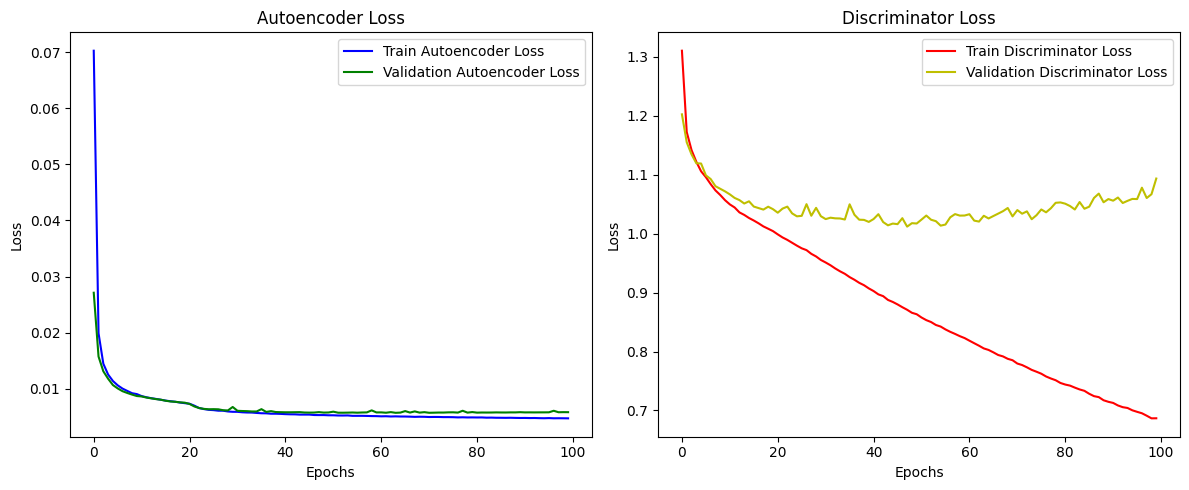

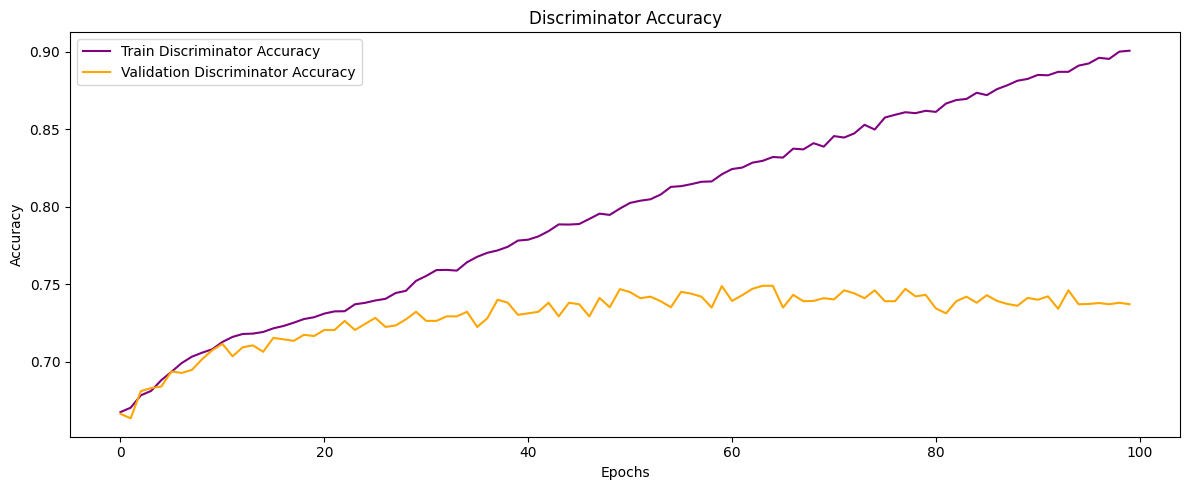

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the loss curves
def plot_loss_curves():
    plt.figure(figsize=(12, 5))

    # Autoencoder loss
    plt.subplot(1, 2, 1)
    plt.plot(autoencoder_losses_epoch, label="Train Autoencoder Loss", color="b")
    plt.plot(val_autoencoder_losses_epoch, label="Validation Autoencoder Loss", color="g")
    plt.title("Autoencoder Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Discriminator loss
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_losses_epoch, label="Train Discriminator Loss", color="r")
    plt.plot(val_discriminator_losses_epoch, label="Validation Discriminator Loss", color="y")
    plt.title("Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot discriminator accuracy
def plot_discriminator_accuracy():
    plt.figure(figsize=(12, 5))

    # Discriminator accuracy
    plt.plot(discriminator_acc_epoch, label="Train Discriminator Accuracy", color="purple")
    plt.plot(val_discriminator_acc_epoch, label="Validation Discriminator Accuracy", color="orange")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to display generated images at regular intervals
def visualize_generated_images(epoch, generated_images, save_dir="generated_images"):
    # Save generated image at the end of the epoch
    if epoch % 10 == 0:  # Adjust frequency as needed
        plt.figure(figsize=(10, 10))
        for i in range(9):  # Display 9 images in a grid
            plt.subplot(3, 3, i+1)
            plt.imshow(generated_images[i])  # Assuming images are in 3x28x28 format
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch}")
        plt.savefig(f"{save_dir}/generated_images_epoch_{epoch}.png")
        plt.show()

# Visualize loss and accuracy
plot_loss_curves()
plot_discriminator_accuracy()

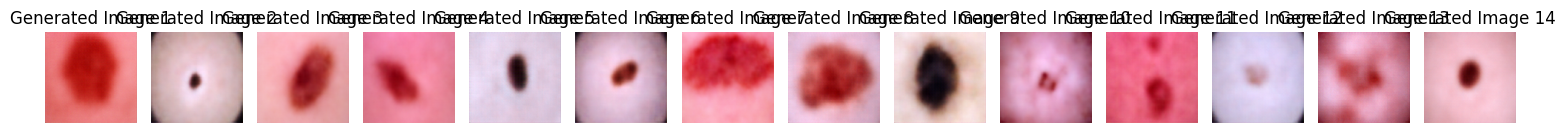

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the directory where the generated images are saved
save_dir = "/kaggle/working"  # Make sure the path is correct

# List the saved generated images
image_files = [f for f in os.listdir(save_dir) if f.endswith('.png')]

# Display a few generated images
num_images_to_show = 14  # You can adjust the number of images to display

plt.figure(figsize=(15, 5))
for i in range(min(num_images_to_show, len(image_files))):
    img_path = os.path.join(save_dir, image_files[i])
    img = mpimg.imread(img_path)
    
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(img)
    plt.axis('off')  # Turn off axes
    plt.title(f'Generated Image {i+1}')
    
plt.tight_layout()
plt.show()


In [12]:
# Evaluate the discriminator and generator on the test data
test_loss_disc, test_acc_disc = discriminator.evaluate(X_test, y_test_one_hot)
print(f"Test Discriminator Loss: {test_loss_disc}, Test Discriminator Accuracy: {test_acc_disc}")

# Evaluate the autoencoder by checking the reconstruction error on the test data
test_loss_auto = autoencoder.evaluate(X_test, X_test)
print(f"Test Autoencoder Loss: {test_loss_auto}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7266 - loss: 1.3107
Test Discriminator Loss: 1.2827863693237305, Test Discriminator Accuracy: 0.7365269660949707
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0061
Test Autoencoder Loss: 0.005951679777354002


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


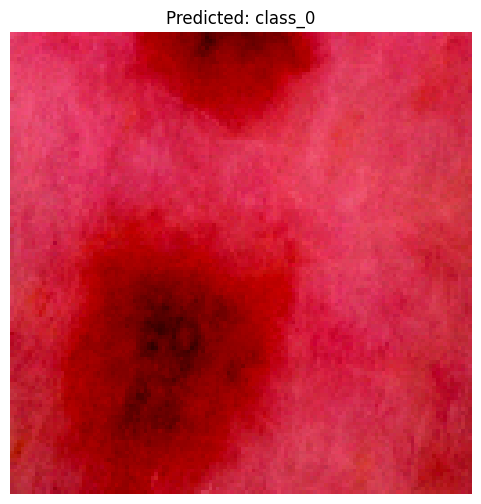

In [13]:
# Function to load and preprocess test images (to match the training format)
def load_test_images(image_dir_1, image_dir_2, img_size=128):
    images = []
    image_paths = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize to [-1,1] for tanh activation
        img_array = image.img_to_array(img) / 127.5 - 1.0  # Normalize to [-1,1]
        images.append(img_array)
        image_paths.append(row['image_id'])  # Store the image id (optional for reference)

    X = np.array(images)
    return X, image_paths

# Load test images
X_test_images, image_ids = load_test_images(image_dir_1, image_dir_2, IMG_SIZE)

# Predict using the trained model (discriminator in this case)
predictions = discriminator.predict(X_test_images)

# Get the predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Function to display an image with its prediction
def show_image_with_prediction(model, image_data, class_names, image_id, true_label=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data)
    
    if true_label is not None:
        plt.title(f"True: {class_names[true_label]} - Pred: {class_names[predicted_classes[image_id]]}")
    else:
        plt.title(f"Predicted: {class_names[predicted_classes[image_id]]}")
    
    plt.axis('off')
    plt.show()

# Define class names (assuming you have 7 classes, update with your actual class names)
class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']  # Adjust as per your labels

# Show prediction for the first test image
show_image_with_prediction(discriminator, X_test_images[4000], class_names, image_id=60)



In [14]:
def load_test_images(image_dir_1, image_dir_2, labels_df, img_size=128):
    images = []
    image_ids = []
    
    for _, row in labels_df.iterrows():
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check where the image exists
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if the image does not exist

        # Convert to numpy array and normalize (match training preprocessing)
        img_array = image.img_to_array(img) / 127.5 - 1.0  # Normalize to [-1,1]

        images.append(img_array)
        image_ids.append(row['image_id'])

    X = np.array(images)
    return X, image_ids

# Load test images
X_test_images, image_ids = load_test_images(image_dir_1, image_dir_2, labels, IMG_SIZE)


In [15]:
class_names = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis',
    3: 'Dermatofibroma',
    4: 'Melanoma',
    5: 'Melanocytic nevus',
    6: 'Vascular lesion'
}


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


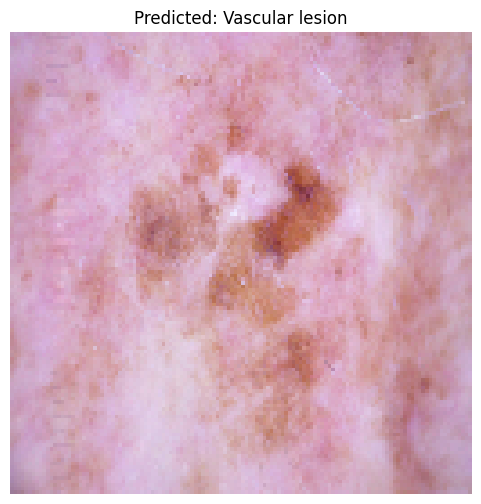

In [16]:
# Get predictions from the trained discriminator model
predictions = discriminator.predict(X_test_images)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Function to display an image with its predicted label
def show_image_with_prediction(image_data, predicted_label):
    plt.figure(figsize=(6, 6))
    plt.imshow((image_data + 1) / 2)  # Convert from [-1,1] back to [0,1]
    
    # Display predicted class name
    plt.title(f"Predicted: {class_names.get(predicted_label, 'Unknown')}")
    
    plt.axis('off')
    plt.show()

# Example: Show prediction for the first test image
show_image_with_prediction(X_test_images[0], predicted_classes[0])
